In [1]:
# set working directory
import sys
import os
sys.path.insert(0, r'd:\Working Folder\Perosnal Projects\ichnofacies')
os.chdir(sys.path[0])

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook"

# Object Detection in Drill Core Photos
In this blog post we will demonstrate how open source python code can be used to rapidly detect and filter shapes in imagery.  The intention is not to produce a perfectly working machine learning model that can accurately classify objects, but more to show how freely available and simple python libraries can be used to speed up common workflows and assist with removing subjectivity from interpretation.  

To demonstrate, we will show a method that can identify trace fossils belonging to ichnofacies in a drill core photo.  The process shows how some coding knowledge can be very valuable when paired with subject matter knowledge.  In this case, programming can help identify the shapes, but only a trained geoscientist could actually identify what these shapes represent and determine their implications.               

In [17]:
# Import libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colormap import hex2rgb, rgb2hex
from fastcore.all import *
from tqdm import tqdm
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)

## Import Image and Pre-processing
The python library Open CV can be used to import images, process them and perform surprisingly accurate object detection.  

First, OpenCV is used to import the photo of a slabbed drill core.  In this case, the photo is of Core 3, cut from ~2247m in the Thylacine-2 exploration well, located in the offshore Otway Basin of Western Victoria.  This well was drilled in 2004 by Origin Energy to appraise a large gas discovery, and the core represents a section of the potential reservoir.  To better understand the depositional setting of the reservoir, sedimentoligists often search for diagnostic 'ichnofacies,' which represent a series of trace fossils that provide indication of the type of environment that existed during the deposition of the host sediments.  However, like any core interpretation, the discrimination of these features from other sedimentary structures is subjective and prone to error.   

To prepare the photo for processing, we add padding around the edges so that the border of the image does not interfere with our process. Then, we binarize it by first converting it to grey-scale and setting a threshold on the color ramp to separate dark hues from lighter ones.  As can be seen in the top left hand side of the image below, Core 3 seems to be a fine grained sandstone, and most of the interesting shapes have a darker colour, so binarizing the image should provide us with a simple first-pass method for detecting shapes of interest.  We can then use the OpenCV findContours method to detect and outline objects in the thresholded image.  

Finally, we can filter the detected objects by calculating the Area of each contour and removing those that are below a threshold.  This leaves us with a series of shapes that could represent a number of important sedimentary structures such as ripple lamination, clay/silt layers, cross bedding and of course trace fossils.

The image below, shows each of the main pre-processing steps, including the raw padded image, the binarized image and the contoured image.  

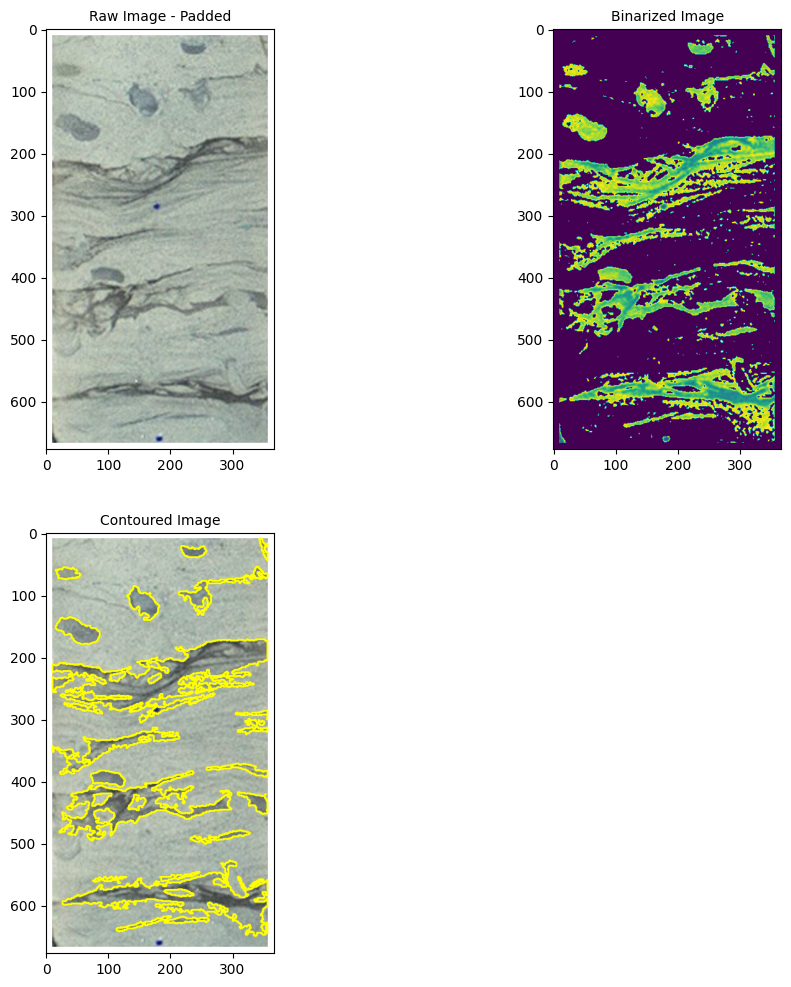

In [83]:
# import image 
core3 = cv2.imread('data/Core2_2247.5_2247.7.png')

# Set threshold for binarization
threshold = 160

# Add a border to the image
white = [255,255,255]
image = cv2.copyMakeBorder(core3, 10, 10, 10, 10, cv2.BORDER_CONSTANT, None, value = white)

# convert the image to greyscale and binarize it
def binarize(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray>threshold]=0
    return gray

im_gray = binarize(image)

# Extract contours
def contours(img:np.ndarray, method:cv2 = cv2.RETR_TREE):
    contours, _ = cv2.findContours(img, method, cv2.CHAIN_APPROX_SIMPLE)
    return contours 

# Create a function that binarizes an images and extracts contours
def get_contours(img:np.ndarray, min_points:int = 3):
    img_gray = binarize(img)
    contours_raw = contours(img_gray)

    return contours_raw # return clean contours

# get contours using the function
cnts = get_contours(image)

#filter contours based on area
area_threshold = 125
filt = []
for (i, c) in enumerate(cnts):
         area = cv2.contourArea(c)
         if area > area_threshold:
                filt.append(c)

image3 = image.copy()
cv2.drawContours(image3, filt, -1, (255,255, 0), 2)

# Display the images
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Raw Image - Padded', fontsize =10)
ax1.imshow(image)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Binarized Image', fontsize =10)
ax2.imshow(im_gray)
ax3 = fig.add_subplot(2,2,3)
ax3.set_title('Contoured Image', fontsize =10)
ax3.imshow(image3)

## Analysis of Contour Properties.  
As can be seen in the third image above we have successfully outlined a number of important features in the photo, but not all of them are trace fossils.  Most trace fossils have fairly distinct radial, concave or convex shapes which differ from other sedimentary structures such as laminations or clay drapes that often have diagonal, linear or amorphous forms.    

It might be possible to discriminate the required shapes by calculating a series of geometric properties for each of the contoured objects and use these as filters.  The properties that we discuss here are described by pyimagesearch n.d. (https://customers.pyimagesearch.com/lesson-sample-advanced-contour-properties/), and they include:

Solidity: Area of Contour / Area of Convex Hull
Extent: Contour Area / Area of Contour Bounding Box
Aspect Ratio: Width / Height of contour

By calculating all of these properties for the detected shapes, we can visualise and inspect them.  

In [84]:
# Calculate geometric properties for each contour, based on pyimagesearch n.d.
# (https://customers.pyimagesearch.com/lesson-sample-advanced-contour-properties/)

# initialise lists of object properties
solidity_index = []
extent_index = []
aspect_ratio_index = []
areas = []
ID = []

for (i, c) in enumerate(filt):
   
    # Calculate Convex Hull
	hull = cv2.convexHull(c)
	hullArea = cv2.contourArea(hull)

	if hullArea > 0:
	    #Calculate area and bounding box
		area = cv2.contourArea(c)
		(x, y, w, h) = cv2.boundingRect(c)
		areas.append(area)

		# Calculate aspect ratio from the width / height of the bounding box
		aspectRatio = w / float(h)
		aspect_ratio_index.append(aspectRatio)

        # Calculate the Solidity Index
		solidity = area / float(hullArea)
		solidity_index.append(solidity)

		# Calculate the extent
		extent = area / float(w * h)
		extent_index.append(extent)

		ID.append(i)

We can use Plotly to visualise the calculated properties for each of the contours.  The Aspect Ratio and Solidity are shown on the X and Y axis respectively, the size of the bubbles reflect the Area and the colour represents the Extent.  

In [86]:
# Create a dataframe of contour properties
object_prop = pd.DataFrame()
object_prop['ID'] = ID
object_prop['Solidity'] = solidity_index
object_prop['Extent'] = extent_index
object_prop['AspectRatio'] = aspect_ratio_index
object_prop['Area'] = areas

# Create a Bubble chart to visualise the properties of the shapes
fig = px.scatter(object_prop, x="AspectRatio", y="Solidity",
	         size="Area", color="Extent",
                 hover_name="ID", log_x=True, size_max=60)
fig.show()
fig.write_html("outputs/bubble.html")

The first key property to interrogate will be the Solidity Index.  This property is calculated by dividing the Area of the Contour by the Area of the Convex Hull.  The Convex Hull represents the minimum enclosing boundary of a shape and therefore the area of the contour itself can never exceed the area of the Convex Hull.  Values of close to 1 indicate an object that has a similar area to that of its convex hull, while Solidity of close to 0 represents a contour with an area that is much less than that of its convex hull.  

By calculating Solidity for each contour and filtering them by less than a threshold of 0.7, we may be able to remove those contours that are irregularly shaped, such as those amorphous clay drapes.  As can be seen on the left hand side of the image below, this process has been successful, but a few small laminations persist.  

To remove more unwanted shapes, we will further filter on the Extent.  The Extent refers to the ratio of the contour area divided by the area of the bounding box of the shape.  This property helps to determine how similar an object is to a rectangle.  By filtering out those objects with an Extent of less than 0.49, it may be possible to remove diagonally oriented linear laminations.   

Number of all contours: 507
Number contours filtered by Solidity: 19
Number contours filtered by Extent: 11


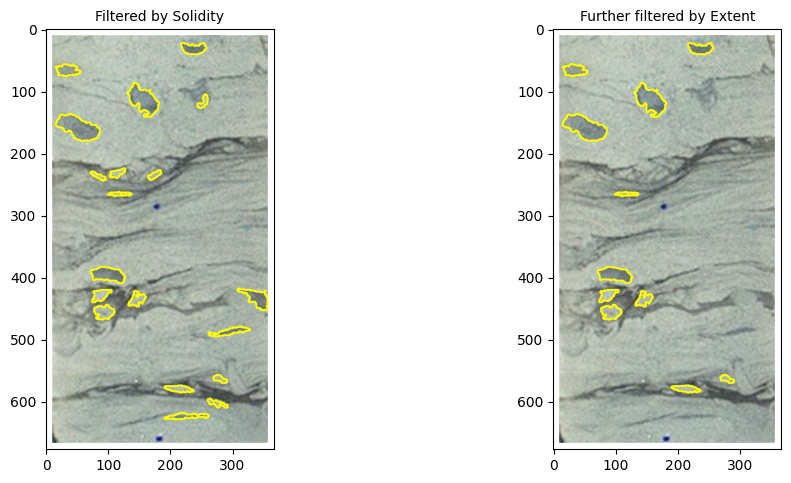

In [88]:
# Use Solidity Index and Extent to remove silt bedding and clay drapes, based on pyimagesearch n.d.

# define thresholds
solidity_threshold = 0.7

# initialise lists of object properties
solidity_index = []
sol =[]
ID = []

for (i, c) in enumerate(filt):
	# calculate the area of each object contour and their respective bounding box
	area = cv2.contourArea(c)
    
    # Calculate Convex Hull and Solidity Index
	hull = cv2.convexHull(c)
	hullArea = cv2.contourArea(hull)
	solidity = area / float(hullArea)
    
	# if the solidity is high (close to 1), then we are likely detecting a round or elliptical shape consistent with ichnofacies
	if solidity > solidity_threshold:
		sol.append(c)
		# append solidity index to list
		solidity_index.append(solidity)
		# append contour ID to list
		ID.append(i)

print("Number of all contours:", len(cnts))	
print("Number contours filtered by Solidity:", len(sol))	

# draw filtered contours onto image
image3 = image.copy()
cv2.drawContours(image3, sol, -1, (255,255, 0), 2)

# filter particles further based on extent
extent_threshold = 0.49

# Initialise lists
filt2 = []
object_id_2 = []

# initialise lists of object properties
for (i, c) in enumerate(sol):
	area = cv2.contourArea(c)
	(x, y, w, h) = cv2.boundingRect(c)
	extent = area / float(w * h)

    # Filter based on extent 
	if extent >= 0.49:
		filt2.append(c)
		#area_c.append(area)
		object_id_2.append(i)

		ID.append(i)

print("Number contours filtered by Extent:", len(filt2))

# draw filtered contours onto image
image4 = image.copy()
cv2.drawContours(image4, filt2, -1, (255,255, 0), 2)

# Visualise the filtered contours
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Filtered by Solidity', fontsize =10)
ax1.imshow(image3)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Further filtered by Extent', fontsize =10)
ax2.imshow(image4)


## Trace Fossil Identification
Upon examining the right hand side of the image above, a series of shapes can be distinguished.  There are some small elongate convex features, two others that are larger and asymmetrically concave and in the top left of the image there are several spherical objects that are clearly larger than any of the other filtered shapes.  

Teichichnus (Te) is a trace fossil made by an organism that distinctively stacks thin slices of sediment as it burrows.  Their trace fossil is normally identified by a concave shape.  Asterosoma (As) is also a trace fossil made by a burrowing organism and normally they are identified by a single large spherical central burrow with lateral burrows that branch out on all sides.  Planolites (Pi) is a trace fossil created by the feeding process of a worm-like animal and is often identified by relatively small elongate, convex shapes.            

We may be able to use a combination of Aspect Ratio and Area to discriminate between these potential trace fossils.  The Aspect Ratio is simply calculated by dividing the object width by the object height.  Objects with an Aspect Ratio of over 1 have a width that is greater than the height and are likely to be elongate features.  Te and Pi fossils would be elongate relative to other shapes in the image and they are likely to have higher Aspect Ratio.  We can use a set of conditional statements to discriminate between Teichichnus (Te) and Planolites (Pi) respectively.   

Since the Asterosoma (As) candidates are clearly the largest shapes on the image, applying a conditional statement with a threshold for Area will help to discriminate them.   

In [89]:
# Identify Ichnofacies based on Aspect Ratio and Area

# copy images to render
image_5 = image.copy()
image_6 = image.copy()

# Create lists of object properties
filt_object_id = []

for (i, c) in enumerate(filt2):

	filt_object_id.append(i)

	# calculate the area and bounding box
	area = cv2.contourArea(c)
	(x, y, w, h) = cv2.boundingRect(c)

    # draw bounding box
	cv2.rectangle(image_6, (x, y), (x+w, y+h), (0, 255, 0), 1)

	# calculate the aspect ratio
	aspectRatio = w / float(h)
    
    # Calculate Convex Hull and Solidity
	hull = cv2.convexHull(c)
	hullArea = cv2.contourArea(hull)
	solidity = area / float(hullArea)
    
	# if the solidity is high (close to 1), then we are likely detecting a round shape

	# draw convex hulls and contours onto image
	cv2.drawContours(image_6, [hull], -1, (255, 255, 0), 1)
	cv2.drawContours(image_6, [c], -1, (240, 0, 159), 1)
	shape = ""

	# prepare annotations
	ar = str(round(aspectRatio,2))
	
	# if the aspect ratio is above 2 then the feature is elongate and probably Te
	if aspectRatio > 2.0 and aspectRatio < 3.0:
		shape = "Te"

	# if the aspect ratio is above below 1 then the feature is more rounded and probably Pi
	if aspectRatio >= 3.0:
		shape = "Pi"

	# if the area is high label as As
	if area >= 1000:
		shape = "As"
	
	# draw the shape name on the image
	cv2.putText(image_6, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		(0, 255, 255), 2)
	cv2.putText(image_6, ar, (x, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		(0, 0, 255), 1)

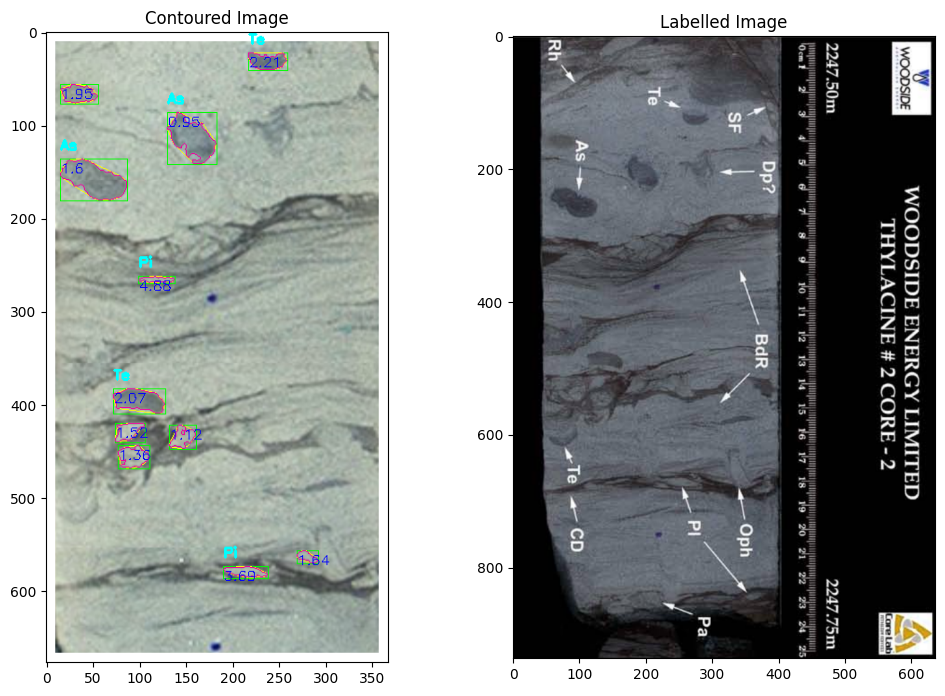

In [90]:
#Import and rotate labelled image
labelled = cv2.imread('data/Core3_Labelled.png')
labelled = cv2.rotate(labelled, cv2.ROTATE_90_CLOCKWISE)

# Display the images
fig = plt.figure(figsize=(12,18))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Contoured Image', fontsize =12)
ax1.imshow(image_6)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Labelled Image', fontsize =12)
ax2.imshow(labelled)

## Conclusion
The left hand side of the image above shows the annotation of our attempted identification of trace fossils.  It also shows the bounding box(green) and contours(red) used to calculate the Extent and Aspect Ratio (annotated in blue), and the Convex Hull(yellow) used to calculate Solidity earlier in this notebook.  Upon comparing with the labelled image on the right, it seems our process has performed reasonably well.  As, Te and Pi are mostly successfully identified.  There are some that were missed by this method, but adjusting the threshold during binarization might help to address this.  

According to the Thylacine-2 Well Completion Report, the trace fossils identified here are components of the Distal Skoliothos Ichnofacies, which was formed by organisms living within a shallow marine setting.  The presence of ripple laminations and clay drapes/laminae indicates deposition within a tidal environment such as an estuary or tidal flat.  A trained geoscientist with some coding ability can speed up data preparation and interpretation, and importantly synthesize information in order to draw meaningful implications.         

This process above could be used to identify trace fossils in the remaining core photos and assist with interpreting changes in the paleo-environment and/or paleo water depth throughout the cored intervals of the well, or to generate training labels to be used in a more advanced classification model.  It might also be used to identify other important sedimentary structures that might assist with determining environments of deposition and reservoir distribution.       